## Imports

In [14]:
import os
import csv
import torch
import torch.nn as nn
import wandb
import numpy as np
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from dataset.dataset import MultiModalDataset
from mmcv_model.mmcv_csn import ResNet3dCSN
from mmcv_model.scheduler import GradualWarmupScheduler

from model.multimodal_neck import MultiModalNeck
from model.simple_head import SimpleHead
from model.flow_autoencoder import FlowAutoencoder

In [3]:
device='cuda'

## Dataloader

In [8]:
test_dataset = MultiModalDataset(ann_file='../../../data/autsl/test_annotations.txt',
                                 root_dir='../../../data/autsl/rawframes',
                                 clip_len=32,
                                 resolution=224,
                                 modalities=('rgb'),
                                 test_mode=True,
                                 frame_interval=1,
                                 input_resolution=512,
                                 num_clips=1
                                 )


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

## Loading the model

In [9]:
# Custom multimodal model
rgb_backbone = ResNet3dCSN(
    pretrained2d=False,
    pretrained=None,
#     pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)


neck = MultiModalNeck()

head = SimpleHead(num_classes=400,
                  in_channels=2048,
                  dropout_ratio=0.5,
                  init_std=0.01)


model = FlowAutoencoder(rgb_backbone=rgb_backbone,
                        neck=neck,
                        head=head)

checkpoint = torch.load('flow_encoder_rgb_autsl_100e.pth')
model.load_state_dict(checkpoint)
model.to(device)

FlowAutoencoder(
  (rgb_backbone): ResNet3dCSN(
    (conv1): ConvModule(
      (conv): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
    (maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (pool2): MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): CSNBottleneck3d(
        (conv1): ConvModule(
          (conv): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (activate): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): ConvModule(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=

In [10]:
def imshow(tensor, idx=0):
    plt.imshow(tensor.permute(1, 2, 3, 0)[idx])
    plt.axis('off')

## Evaluation

In [12]:
# Calculate accuracy
df = pd.DataFrame(columns=['class_id', 'prediction_id'])

for i, batch in enumerate(test_loader):
    model.eval()

    with torch.inference_mode():
        cls_score = model(batch['rgb'].to(device))

    df.loc[len(df)+1] = (batch['label'].item(), cls_score.argmax().item())

In [17]:
class_list = dict()
with open("./class_id_autsl.csv", 'r') as file:
    csvreader = csv.reader(file)
    for i, row in enumerate(csvreader):
        if i==0:
            continue
        class_list[row[0]] = row[2]

In [ ]:
class_list = dict()
with open('../wlasl_class_list.txt', 'r') as fin:
    line = fin.readline()
    while line:
        values = line.split()
        class_list[values[0]] = values[1]
        line = fin.readline() 

In [20]:
df['gloss'] = df.apply(lambda x: class_list[str(x['class_id'])], axis=1)
df['prediction'] = df.apply(lambda x: class_list[str(x['prediction_id'])], axis=1)
df['correct'] = df['class_id'] == df['prediction_id']

In [21]:
df.head()

class_id  prediction_id     gloss prediction  correct
1       157            157    sunday     sunday     True
2       158            158    monday     monday     True
3        28             28    single     single     True
4       126            126  scissors   scissors     True
5       179            179      love       love     True

In [22]:
len(df[df['correct']==True])/len(test_loader)

0.9029671210906175

In [23]:
df_confusion = pd.crosstab(df['gloss'], df['prediction'])

In [24]:
x = list(df['prediction'].unique())

In [25]:
y = list(df['gloss'].unique())

In [26]:
for value in y:
    if value in x:
        y.remove(value)

In [27]:
y

['monday',
 'scissors',
 'teacher',
 'honey',
 'mince',
 'they',
 'door',
 'manager',
 'we',
 'unwise',
 'identity',
 'carpet',
 'say',
 'grandfather',
 'child',
 'ataturk',
 'football',
 'fault',
 'shoe',
 'book',
 'bring',
 'hospital',
 'same',
 'wood',
 'apologize',
 'egg',
 'school',
 'free',
 'sauce',
 'brother',
 'fasting',
 'grandmother',
 'olympiad',
 'screwdriver',
 'hi',
 'umbrella',
 'psychology',
 'salary',
 'needle',
 'comb',
 'tuesday',
 'family',
 'sibling',
 'wise',
 'be_pleased',
 'hour',
 'why',
 'dog',
 'band-aid',
 'lap',
 'father',
 'accident',
 'who',
 'difficult',
 'tailor',
 'garden',
 'thanks',
 'animal',
 'ugly',
 'police',
 'change',
 'ceiling',
 'danger',
 'topple',
 'bed',
 'guest',
 'you',
 'soap',
 'cook',
 'stain',
 'always',
 'wall',
 'trousers',
 'meal',
 'bridge',
 'crossroads',
 'full',
 'war',
 'saturday',
 'how',
 'friday',
 'teapot',
 'drink',
 'wednesday',
 'yes',
 'money',
 'pencil',
 'pillow',
 'get_well',
 'near',
 'do',
 'right',
 'thursday',

In [28]:
plt.subplots(figsize=(80,70), dpi=300)
sns.heatmap(df_confusion, cmap='viridis')
sns.set(font_scale = 3)
plt.xlabel('Prediction', fontsize=40)
plt.ylabel('Gloss', fontsize=40)

Text(2913.166666666667, 0.5, 'Gloss')

In [29]:
df.head()

class_id  prediction_id     gloss prediction  correct
1       157            157    sunday     sunday     True
2       158            158    monday     monday     True
3        28             28    single     single     True
4       126            126  scissors   scissors     True
5       179            179      love       love     True

### Heatmap on the wrong predictions

In [30]:
wrong_df = df[df['prediction']!=df['gloss']]

In [31]:
df_confusion = pd.crosstab(wrong_df['gloss'], wrong_df['prediction'])

Text(783.25, 0.5, 'Gloss')

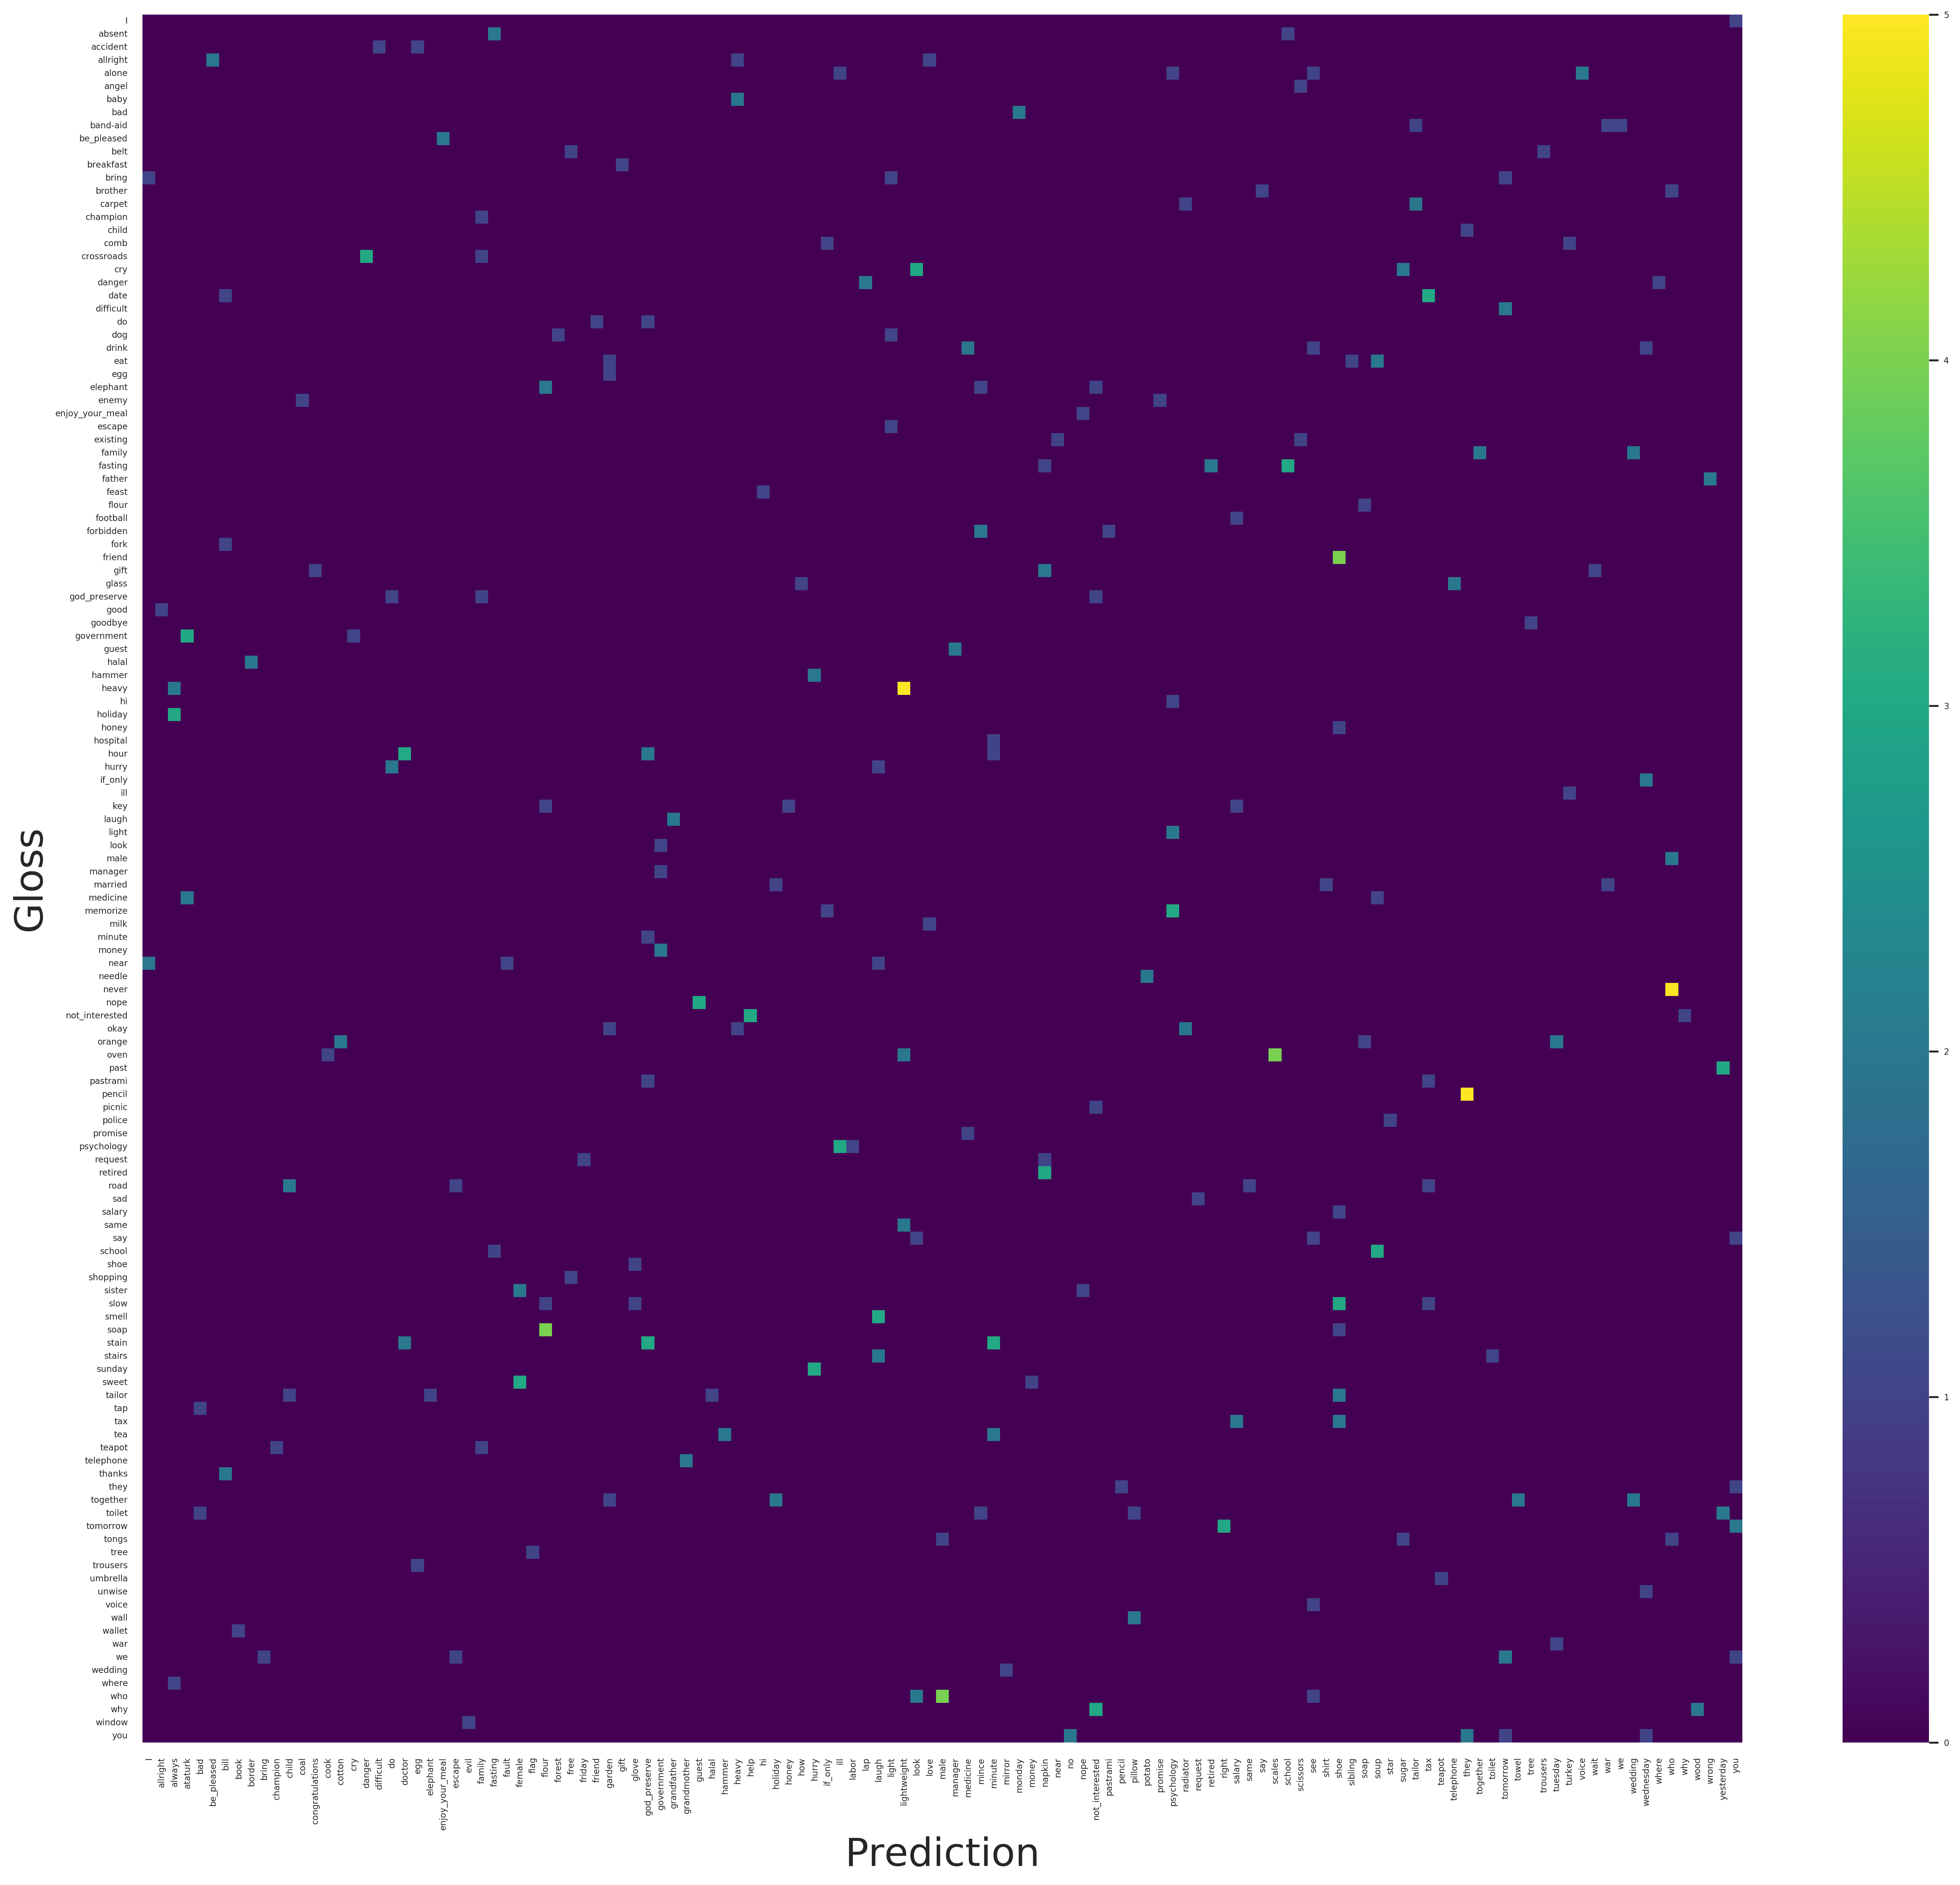

In [37]:
plt.subplots(figsize=(23,20), dpi=300)
sns.heatmap(df_confusion, cmap='viridis')
# sns.set(font_scale = 0.5)
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Gloss', fontsize=25)

In [112]:
class_list

{'0': 'book',
 '1': 'drink',
 '2': 'computer',
 '3': 'before',
 '4': 'chair',
 '5': 'go',
 '6': 'clothes',
 '7': 'who',
 '8': 'candy',
 '9': 'cousin',
 '10': 'deaf',
 '11': 'fine',
 '12': 'help',
 '13': 'no',
 '14': 'thin',
 '15': 'walk',
 '16': 'year',
 '17': 'yes',
 '18': 'all',
 '19': 'black',
 '20': 'cool',
 '21': 'finish',
 '22': 'hot',
 '23': 'like',
 '24': 'many',
 '25': 'mother',
 '26': 'now',
 '27': 'orange',
 '28': 'table',
 '29': 'thanksgiving',
 '30': 'what',
 '31': 'woman',
 '32': 'bed',
 '33': 'blue',
 '34': 'bowling',
 '35': 'can',
 '36': 'dog',
 '37': 'family',
 '38': 'fish',
 '39': 'graduate',
 '40': 'hat',
 '41': 'hearing',
 '42': 'kiss',
 '43': 'language',
 '44': 'later',
 '45': 'man',
 '46': 'shirt',
 '47': 'study',
 '48': 'tall',
 '49': 'white',
 '50': 'wrong',
 '51': 'accident',
 '52': 'apple',
 '53': 'bird',
 '54': 'change',
 '55': 'color',
 '56': 'corn',
 '57': 'cow',
 '58': 'dance',
 '59': 'dark',
 '60': 'doctor',
 '61': 'eat',
 '62': 'enjoy',
 '63': 'forget',


In [38]:
df

class_id  prediction_id     gloss prediction  correct
1          157            157    sunday     sunday     True
2          158            158    monday     monday     True
3           28             28    single     single     True
4          126            126  scissors   scissors     True
5          179            179      love       love     True
...        ...            ...       ...        ...      ...
3737       120            120       dog        dog     True
3738       181            181    border     border     True
3739        88             88    animal     animal     True
3740       170            170       hat        hat     True
3741        34             73        we      bring    False

[3741 rows x 5 columns]